In [1]:
import gc
import os
import time
import math
import copy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

import warnings
warnings.filterwarnings('ignore')

gc.collect()

3

In [2]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def getPositions(G):
    return [tuple(i[1].values()) for i in G.nodes.data()]

def getLabels(G):
    return [i[0] for i in G.nodes.data()]

def saveGraph(G, pos, label, title, path):
    f = plt.figure()
    nx.draw_networkx(
        G, 
        pos=pos, 
        node_size=200, 
        label=label,
        node_color="yellow",
        ax=f.add_subplot(111),
    )
    f.suptitle(title, fontsize=20)
    f.savefig(path)
    plt.close()
    
def getTotalWeight(G, tour):
    total_weight = 0
    for i in range(nx.number_of_nodes(G) - 1):
        total_weight = total_weight + G.edges[tour[i], tour[i+1]]['weight']
    total_weight = total_weight + G.edges[tour[0], tour[n - 1]]['weight']
    return total_weight

In [3]:
def generateComTree(n, plot=False):
    G = nx.Graph()
    for index in range(n):
        G.add_node(
            index, 
            x=np.random.uniform(), 
            y=np.random.uniform()
        )
    
    
    for ind1 in range(n):
        for ind2 in range(n):
            G.add_edge(
                ind1, ind2, 
                weight=distance(
                    list(G.nodes[ind1].values()), list(G.nodes[ind2].values())
                )
            )
            
    positions = [tuple(i[1].values()) for i in G.nodes.data()]
    labels = [i[0] for i in G.nodes.data()]
    if plot:
        nx.draw_networkx(
            G, pos=positions, 
            node_size=200, label=labels,
            node_color="yellow"
        )
    return G

In [4]:
def run_greedy_TSP(G, pos=None, label=None, should_print=True):
    
    if not pos:
        pos = getPositions(G)
    if not label:
        label = getLabels(G)
    

    start_time = time.time()
    n=nx.number_of_nodes(G)
    tour=[0]
    nr_cities=0
    length_tour=0


    while nr_cities<n-1:
        min_weight=999999
        candidate=-1
        for i in range(0,n):
            if (i not in tour):
                if G.edges[tour[nr_cities],i]['weight']< min_weight:
                    min_weight=G.edges[tour[nr_cities],i]['weight']
                    candidate=i
        tour.append(candidate)
        nr_cities=nr_cities+1
        length_tour=length_tour+min_weight

    
    length_tour=length_tour+G.edges[0,tour[n-1]]['weight']
    final_time=time.time() - start_time

    
    G_final=nx.Graph()
    for i in range(n-1):
        G_final.add_edge(
            tour[i], tour[i+1], 
            weight=G.edges[tour[i], tour[i+1]]['weight']
        )
    G_final.add_edge(
        tour[0], tour[n-1], 
        weight=G.edges[tour[0], tour[n-1]]['weight']
    )


    if should_print:
        nx.draw_networkx_labels(G_final, pos, node_size=100, label=label)
        nx.draw_networkx(G_final, pos, node_size=200)
        plt.show()

    return {
        'total_weight': length_tour, 
        'tour': tour, 
        'used_time': final_time, 
        'graph': G_final, 
        'position': pos, 
        'label': label
    }

In [5]:
def run_2opt_TSP(G, tour, pos=None, label=None, should_print=True):
    
    tourCopy = copy.deepcopy(tour)
    if not pos:
        pos = getPositions(G)
    if not label:
        label = getLabels(G)
    n = nx.number_of_nodes(G)

    
    start_time = time.time()
    for j in range(1, len(tourCopy)):
        for i in range(j):
            
            J_end_point = j+1
            if J_end_point == len(tourCopy):
                J_end_point = 0
            I_end_point = i+2
            if I_end_point == len(tourCopy):
                I_end_point = 0
            
            newTour = copy.deepcopy(tourCopy)
            tmpJ = tourCopy[j]
            tmpI = tourCopy[i+1]
            newTour[i+1] = tmpJ
            newTour[j] = tmpI
            
            newWeight = getTotalWeight(G, newTour)
            oriWeight = getTotalWeight(G, tourCopy)
            
            if newWeight < oriWeight:
                tourCopy = newTour
    end_time = time.time()
    
    n = len(tourCopy)
    G_final = nx.Graph()
    for i in range(n - 1):
        G_final.add_edge(
            tourCopy[i], tourCopy[i+1], 
            weight=G.edges[tourCopy[i], tourCopy[i+1]]['weight']
        )
    G_final.add_edge(
        tourCopy[n - 1], tourCopy[0],
        weight=G.edges[tourCopy[n-1], tourCopy[0]]['weight']
    )
    
    if should_print:
        nx.draw_networkx_labels(G_final, pos, node_size=100, label=label)
        nx.draw_networkx(G_final, pos, node_size=200)
        plt.show()
    
    return {
        'total_weight': getTotalWeight(G, tourCopy), 
        'tour': tourCopy, 
        'used_time': end_time - start_time, 
        'graph': G_final, 
        'position': pos, 
        'label': label
    }

### Run one time

In [6]:
n = 20
G = generateComTree(n)        
greedy_result = run_greedy_TSP(G, should_print=False)
opt_result = run_2opt_TSP(G, greedy_result['tour'], should_print=False)

----- Greedy -----
total weight: 3.9288
tour:  [0, 11, 4, 8, 19, 15, 14, 9, 18, 3, 1, 5, 6, 17, 16, 13, 2, 7, 10, 12]


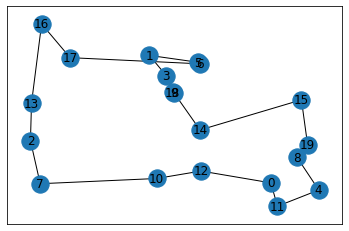

In [7]:
print('-'*5, 'Greedy', '-'*5)
nx.draw_networkx(greedy_result['graph'], pos=greedy_result['position'], label=greedy_result['label'])
print('total weight: %.4f' % greedy_result['total_weight'])
print('tour: ', greedy_result['tour'])

----- 2-OPT -----
total weight: 3.7549
tour:  [0, 11, 4, 8, 19, 15, 14, 9, 18, 3, 6, 5, 1, 16, 17, 13, 2, 7, 10, 12]


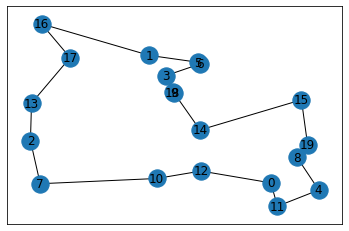

In [8]:
print('-'*5, '2-OPT', '-'*5)
nx.draw_networkx(opt_result['graph'], pos=opt_result['position'], label=opt_result['label'])
print('total weight: %.4f' % opt_result['total_weight'])
print('tour: ', opt_result['tour'])

### Problem 1

In [9]:
times = 20
dataDict = {}
improveDict = {}

for n in [30, 40, 50]:
    dataDict[n] = {'greedy': [], 'opt': []}
    improveDict[n] = []
    
    for _ in range(times):
        G = generateComTree(n)
        
        greedy_result = run_greedy_TSP(G, should_print=False)
        dataDict[n]['greedy'].append(greedy_result['total_weight'])
        
        opt_result = run_2opt_TSP(G, greedy_result['tour'], should_print=False)
        dataDict[n]['opt'].append(opt_result['total_weight'])
        
        improveDict[n].append(
            (greedy_result['total_weight'] - opt_result['total_weight'])/greedy_result['total_weight']
        )

In [10]:
dict_of_df = {k: pd.DataFrame(v) for k,v in dataDict.items()}
df = pd.concat(dict_of_df, axis=1)

In [11]:
df

30                  40                  50          
      greedy       opt    greedy       opt    greedy       opt
0   6.290389  5.668561  5.625180  5.345073  6.869737  6.579793
1   5.438839  4.983832  6.120808  6.038762  7.401617  7.176296
2   5.850647  5.567727  6.649986  6.510050  7.749110  7.627620
3   4.558886  4.401614  5.274539  5.218598  7.228235  7.097188
4   4.883357  4.615482  6.336409  6.031874  7.660056  7.462905
5   4.682797  4.583605  7.295611  7.196221  7.398944  7.284340
6   5.214971  4.991595  6.211030  6.056130  6.689539  6.507685
7   5.261149  5.097941  7.327939  7.136925  7.427349  7.160882
8   5.905779  5.742908  6.748020  6.601674  6.287426  6.181183
9   5.564471  5.351619  5.775934  5.616874  6.901129  6.697277
10  5.778983  5.644521  6.183659  6.072397  7.296561  7.290365
11  5.824396  5.702629  6.143594  5.953209  7.107119  7.012899
12  4.870065  4.587941  5.463514  5.214844  6.682645  6.547947
13  5.741053  5.651001  5.760555  5.572873  7.314488  7.002380
14  6.226056  6.167105  6.638711  6.384771  6.819446  6.749019
15  4.966046  4.872100  5.472722  5.333933  6.801580  6.418255
16  4.866665  4.861902  5.960752  5.854342  7.656641  7.342712
17  6.261532  6.105485  6.037488  5.841615  7.640021  7.631013
18  5.371117  5.260968  6.762128  6.364474  6.494299  6.321472
19  5.214306  5.144896  6.598053  6.333761  7.829440  7.086699

In [12]:
for n, imp in pd.DataFrame(improveDict).mean(axis=0).iteritems():
    print('when n=%0.f 2-OPT makes %.4f%s improvement over greedy method' % (n, imp*100, '%'))

when n=30 2-OPT makes 3.4349% improvement over greedy method
when n=40 2-OPT makes 2.9830% improvement over greedy method
when n=50 2-OPT makes 2.8223% improvement over greedy method
